## Setting up the imports 

In [3]:
import re
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller            
from statsmodels.tsa.seasonal import STL  
from statsmodels.tsa.stattools import kpss
import statsmodels.api as sm
from sklearn.decomposition import PCA
import pywt
import calendar
from statsmodels.graphics.tsaplots import month_plot
import scipy.stats as st
from arch import arch_model
from statsmodels.stats.diagnostic import acorr_ljungbox
import datetime


## Data prep

### Vintages

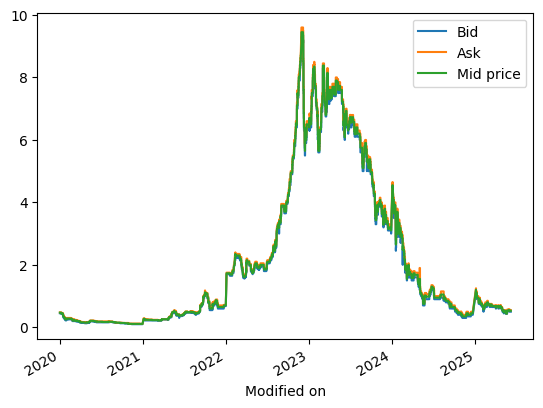

In [4]:
df = pd.read_csv('data/merged_hydro.csv')
df['Modified on']=pd.to_datetime(df['Modified on'], utc=True).dt.tz_localize(None)

df.plot(kind = 'line', x = 'Modified on')

df['log_mid'] = np.log(df['Mid price'])

df['return'] = df['log_mid'].diff()

array([<Axes: xlabel='Modified on'>, <Axes: xlabel='Modified on'>,
       <Axes: xlabel='Modified on'>, <Axes: xlabel='Modified on'>,
       <Axes: xlabel='Modified on'>], dtype=object)

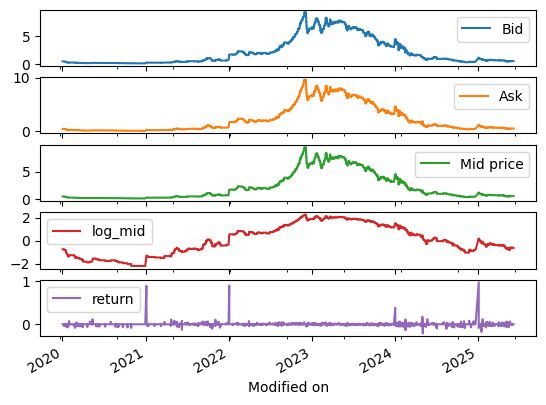

In [5]:
df.plot(kind = 'line', x = 'Modified on', subplots = True)

In [6]:
spot = df.copy()

spot['vintage'] = (
    spot['Product code']              
        .str.extract(r'(\d{4})$')      
        .astype(int)                 
)
 
spot['vintage_switch'] = spot['vintage'].ne(spot['vintage'].shift(-1))

spot['return_cleaned'] = spot['log_mid'].diff()

mask_jump = spot['vintage_switch'].shift(1, fill_value=False)
spot.loc[mask_jump, 'return_cleaned'] = np.nan

print("Injected NaNs at roll dates:", mask_jump.sum())


Injected NaNs at roll dates: 5


In [7]:
spot['Modified on']=pd.to_datetime(df['Modified on'], utc=True).dt.tz_localize(None)

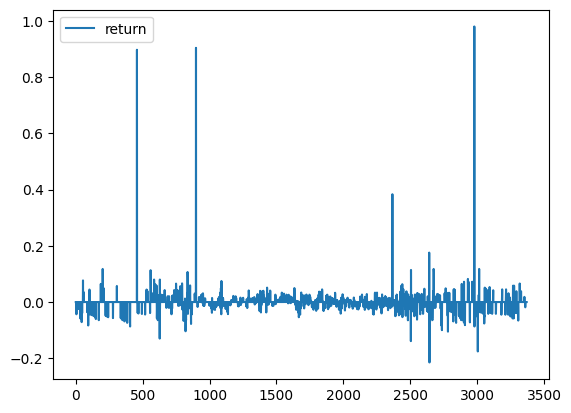

<Axes: >

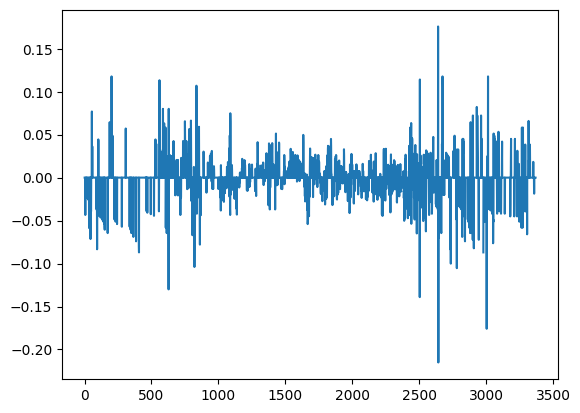

In [8]:
spot[['return']].plot(kind='line')
plt.show()
spot['return_cleaned'].plot(kind='line')

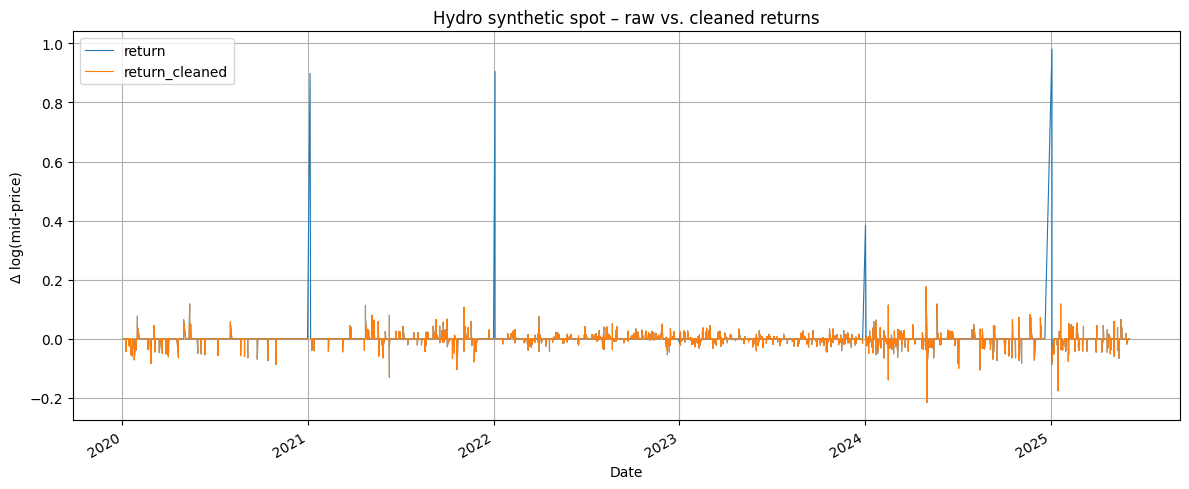

In [9]:
spot['Modified on'] = (
    pd.to_datetime(spot['Modified on'], utc=True, errors='coerce')
      .dt.tz_localize(None)       
)
spot = spot.set_index('Modified on').sort_index()


ax = spot[['return', 'return_cleaned']].plot(
        figsize=(12, 5),
        lw=0.8,
        title='Hydro synthetic spot – raw vs. cleaned returns',
        grid=True
)
ax.set_xlabel('Date')
ax.set_ylabel('Δ log(mid-price)')
plt.tight_layout()
plt.show()

### Water levels (Norway)

In [10]:
water = pd.read_csv('data/water_combined_long.csv')

# 1) Add an actual Date column from Year+Week (ISO‐week → Monday of that week)
mask_w53 = (water['Week'] == 53) 
water = water.loc[~mask_w53]
water['StoredEnergy'] = pd.to_numeric(water['StoredEnergy'], errors='coerce')

water['Date'] = water.apply(
    lambda r: datetime.date.fromisocalendar(r['Year'], r['Week'], 1),
    axis=1
)

water['Date'] = pd.to_datetime(water['Date'])


# 3) Filter out any “too recent” rows: keep only up to (current week − 2) for the current year
today = datetime.date.today()
cy, cw, _ = today.isocalendar()       # cy = current year, cw = current ISO week
# build a Boolean index: 
#   keep everything from past years, 
#   and in the current year only those with Week ≤ cw−2
mask_too_new = (water['Year'] == cy) & (water['Week'] > max(cw - 2, 0))
water = water.loc[~mask_too_new]

# 4) Impute missing StoredEnergy by linear interpolation within each country
#    (you can also ffill/bfill or other methods if you prefer)
water = water.sort_values(['Country','Date'])
# *** Here’s the only change: use transform() rather than apply() ***
water['StoredEnergy'] = (
    water
    .groupby('Country')['StoredEnergy']
    .transform(lambda s: s.interpolate(method='linear'))
)

# now your DataFrame has a Date column, 
# no spurious Wk 53, only up through (this week−2), and no gaps in StoredEnergy
print(water.head())

   Country Region  Year  Week  StoredEnergy       Date
0  Austria   Alps  2019     1     1412194.0 2018-12-31
1  Austria   Alps  2019     2     1372937.0 2019-01-07
2  Austria   Alps  2019     3     1326312.0 2019-01-14
3  Austria   Alps  2019     4     1176602.0 2019-01-21
4  Austria   Alps  2019     5     1077808.0 2019-01-28


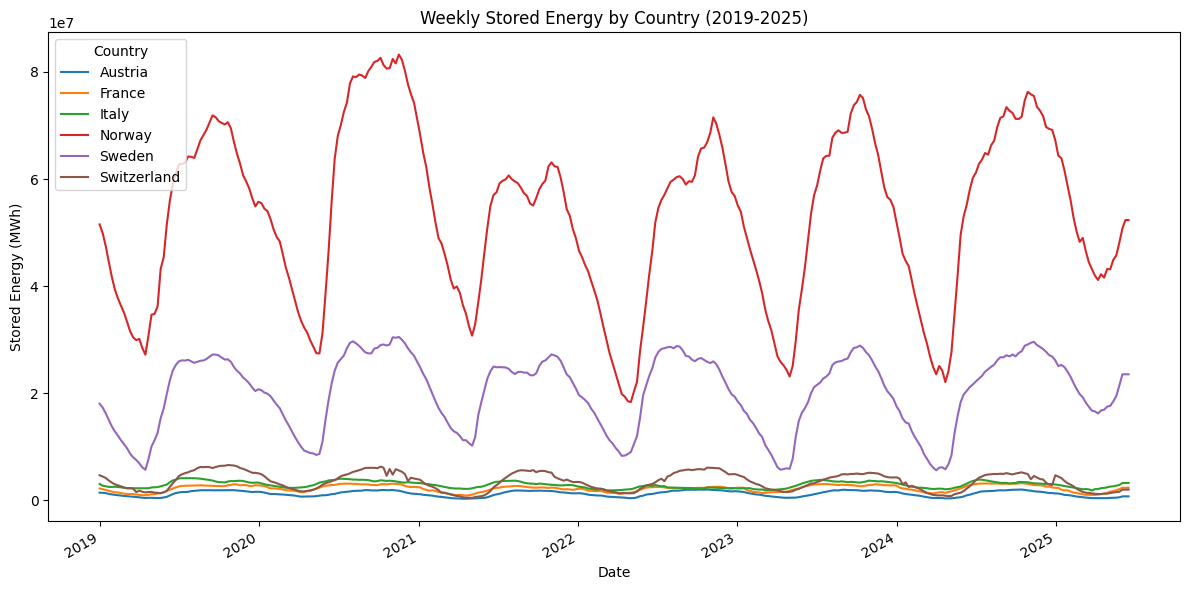

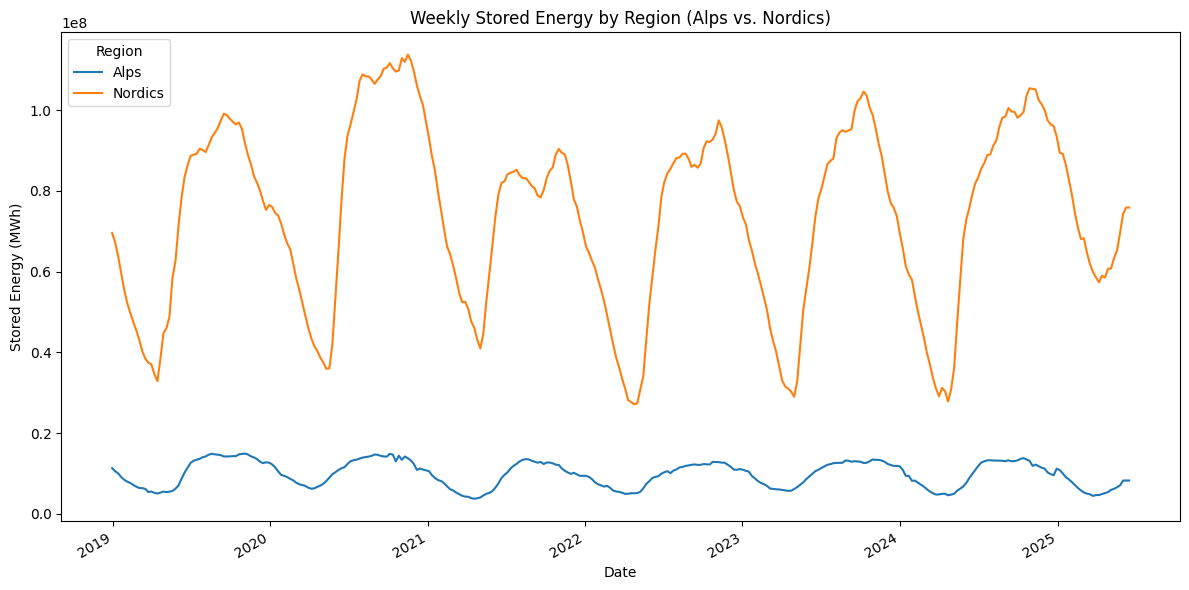

<Figure size 640x480 with 0 Axes>

In [11]:
pivot_country = (
    water.pivot_table(
        index='Date',
        columns='Country',
        values='StoredEnergy',
        aggfunc='mean'     # change to 'mean' if you prefer averages
    )
    .sort_index()
)
plt.figure(figsize=(12, 6))
pivot_country.plot(ax=plt.gca())
plt.title('Weekly Stored Energy by Country (2019-2025)')
plt.xlabel('Date')
plt.ylabel('Stored Energy (MWh)')
plt.legend(title='Country', loc='upper left')
plt.tight_layout()
plt.show()

# 5. -------- Plot 2: regional graph --------
pivot_region = (
    water.groupby(['Date', 'Region'])['StoredEnergy']
    .sum()
    .unstack('Region')
    .sort_index()
)

plt.figure(figsize=(12, 6))
pivot_region.plot(ax=plt.gca())
plt.title('Weekly Stored Energy by Region (Alps vs. Nordics)')
plt.xlabel('Date')
plt.ylabel('Stored Energy (MWh)')
plt.legend(title='Region', loc='upper left')
plt.tight_layout()
plt.show()

plt.savefig('results/hydro_storage.png', dpi=300, bbox_inches='tight')

# Seasonality checks

Here we attempt to model seasonality and see the repeating patterns for the returns behaviour on different scales